In [1]:
import os
import copy
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models

from sklearn.metrics import f1_score, classification_report

import lightning as L
from lightning import Fabric

import pickle

In [2]:
DATA_DIR = 'data/img_align_celeba/img_align_celeba/'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ys = pd.read_csv('data/list_attr_celeba.csv')

In [3]:
val_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [11]:
import numpy as np
from scipy.optimize import differential_evolution
from PIL import Image
import torch
from torchvision import transforms

# Transformation pipeline
val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def one_pixel_attack(
        pil_image: Image.Image, 
        model: torch.nn.Module, 
        target: int,
        num_pixels: int,
        diameter: int = 1,
        maxiter: int = 75, 
        popsize: int = 400,
        timelimit: float = float('inf'),
        strategy='best1bin') -> list:
    """
    Perform a one-pixel (or few-pixels) attack on the given image to flip the model's binary decision.
    
    Args:
    pil_image: Input image as a PIL.Image.
    model: Pretrained torch model that outputs a single scalar score.
    num_pixels: Number of pixels allowed to modify.
    maxiter: Maximum number of iterations for differential evolution.
    popsize: Population size multiplier for differential evolution.
    
    Returns:
    A list of tuples: (x, y, R, G, B) for each modified pixel.
    """
    # Image dimensions
    img_arr = np.array(pil_image)
    H, W = img_arr.shape[:2]
    
    # Bounds: for each pixel we need x, y, r, g, b
    bounds = []
    for _ in range(num_pixels):
        bounds.extend([
            (0, W - 1), # x coordinate
            (0, H - 1), # y coordinate
            (0, 255), # R
            (0, 255), # G
            (0, 255), # B
        ])

    score_cache = {}
    current_min = float('inf') if target == 0 else float('-inf')
    start = time.time()
        
    def perturb(x: np.ndarray) -> np.ndarray:
        """Модифицирует изображение, изменяя пиксели на основе параметров x."""
        img_mod = img_arr.copy()
        px = x.reshape((num_pixels, 5)).astype(int)
        for xi in px:
            x_coord, y_coord, r, g, b = xi
            for delta_x in range(diameter):
                for delta_y in range(diameter):
                    if y_coord + delta_y < img_mod.shape[0] and x_coord + delta_x < img_mod.shape[1]:
                        img_mod[y_coord + delta_y, x_coord + delta_x] = [r, g, b]
        return img_mod
    
    def get_score(x: np.ndarray) -> float:
        """Вычисляет score для набора параметров x, используя кэш."""
        nonlocal current_min
        x_tuple = tuple(x)  # Преобразуем массив в кортеж для кэширования
        if x_tuple in score_cache:
            return score_cache[x_tuple]
        pert = perturb(x)
        pil_pert = Image.fromarray(pert)
        inp = val_tfms(pil_pert).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            # score = model(inp).item()
            score = model(inp).squeeze(1).cpu()
            score = torch.sigmoid(score).numpy()[0]
        score_cache[x_tuple] = score
        if target == 0 and score < current_min:
            current_min = score
            # print(score)
        if target == 1 and score > current_min:
            current_min = score
            # print(score)
        return score
    
    def objective(x: np.ndarray) -> float:
        """Целевая функция для минимизации."""
        score = get_score(x)
        return score if target == 0 else 1-score
    
    def callback(xk, convergence):
        """Проверка условия остановки."""
        if time.time() - start > timelimit:
            # print(current_min)
            return True
        print(xk)
        score = get_score(xk)
        if (target == 0 and score < 0.5) or (target == 1 and score > 0.5):
            # print(current_min)
            return True
        return False
    
    # Запуск дифференциальной эволюции
    result = differential_evolution(
        objective,
        bounds,
        maxiter=maxiter,
        strategy=strategy,
        popsize=popsize,
        tol=1e-5,
        polish=True,
        callback=callback
    )
    
    # Parse result
    best = result.x.reshape((num_pixels, 5)).astype(int)
    attack_pixels = [(int(x), int(y), int(r), int(g), int(b)) for x, y, r, g, b in best]
    best_score = get_score(result.x)
    
    return attack_pixels, best_score

ERROR! Session/line number was not unique in database. History logging moved to new session 617


In [5]:
import time
import numpy as np
import torch
import pyswarms as ps
from PIL import Image

def pso_one_pixel_attack(model, image: Image.Image, 
                         true_class: int,
                         max_pixels: int = 1,
                         time_limit: float = 20 * 60,
                         swarm_size: int = 50,
                         diameter: int = 1,
                         iters: int = 1000):
    """
    Perform a one-pixel (or multi-pixel) adversarial attack on a PIL image using Particle Swarm Optimization
    with manual iteration and stopping conditions.
    """
    img_arr = np.array(image)
    height, width, channels = img_arr.shape
    dims = max_pixels * (2 + channels)

    # Задаём границы поиска
    lb = np.zeros(dims)
    ub = np.zeros(dims)
    for i in range(max_pixels):
        idx = i * (2 + channels)
        lb[idx:idx+2] = 0
        ub[idx]   = width - 1
        ub[idx+1] = height - 1
        lb[idx+2:idx+2+channels] = 0
        ub[idx+2:idx+2+channels] = 255
    bounds = (lb, ub)

    # Функция фитнеса
    def fitness_fn(particles):
        n = particles.shape[0]
        batch = []
        for i, particle in enumerate(particles):
            mod = img_arr.copy()
            for px in range(max_pixels):
                base = px * (2 + channels)
                x = int(np.clip(particle[base],   0, width - 1))
                y = int(np.clip(particle[base+1], 0, height - 1))
                vals = particle[base+2:base+2+channels].astype(int)
                
                for delta_x in range(diameter):
                    for delta_y in range(diameter):
                        if y + delta_y < mod.shape[0] and x + delta_x < mod.shape[1]:
                            mod[y + delta_y, x + delta_x] = vals
            pil = Image.fromarray(mod)
            inp = val_tfms(pil).unsqueeze(0)
            batch.append(inp)
        batch = torch.cat(batch).to(DEVICE)
        with torch.no_grad():
            out = torch.sigmoid(model(batch).squeeze(1)).cpu().numpy()
        # хотим минимизировать -score, где score = P(wrong_class)
        if true_class == 0:
            score = out  # хотим повысить P(класса 1)
        else:
            score = 1 - out  # хотим повысить P(класса 0)
        return -score

    # Инициализируем оптимизатор
    options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
    optimizer = ps.single.GlobalBestPSO(n_particles=swarm_size,
                                        dimensions=dims,
                                        options=options,
                                        bounds=bounds)

    start = time.time()
    best_cost = 0

    # Основной цикл PSO
    for iteration in range(iters):
        cost, pos = optimizer.optimize(fitness_fn, iters=1, verbose=False)
        # cost — это текущий глобальный лучший (минимальный) negative score
        if cost < best_cost:
            best_cost = cost
            # print(-best_cost)
        # проверяем, достигли ли нужного уровня (например, -best_cost > 0.5)
        if -best_cost > 0.5:
            # print(f"Stopped at iteration {iteration+1}: target reached.")
            break
        # проверяем таймаут
        if time.time() - start > time_limit:
            # print(f"Stopped at iteration {iteration+1}: time limit exceeded.")
            break

    # Получаем лучшую позицию
    swarm = optimizer.swarm
    best_pos = swarm.best_pos
    best_cost = swarm.best_cost

    # Подготавливаем вывод пикселей
    pixels = []
    for px in range(max_pixels):
        base = px * (2 + channels)
        x = int(np.clip(best_pos[base],   0, width - 1))
        y = int(np.clip(best_pos[base+1], 0, height - 1))
        vals = best_pos[base+2:base+2+channels].tolist()
        pixels.append([x, y] + list(map(int, vals)))
    return pixels, -best_cost

In [6]:
import os
from typing import List, Tuple
import numpy as np
import torch
from PIL import Image
from src.gen_alg import GeneticAlgorithm

# Генераторы значений для генов
def make_gene_ranges(image_shape: Tuple[int, int], diameter: int) -> List[List[int]]:
    H, W = image_shape
    # x, y и три цветовых канала (0–254)
    return [
        list(range(0, H - diameter + 1)),  # x
        list(range(0, W - diameter + 1)),  # y
        list(range(255)),                  # R
        list(range(255)),                  # G
        list(range(255)),                  # B
    ]

# Представление «атаки» как тройки (x, y, [r, g, b])
Perturbation = Tuple[int, int, List[int]]

def apply_perturbation(image: np.ndarray, p: Perturbation, diameter: int) -> None:
    x, y, (r, g, b) = p
    for dx in range(diameter):
        for dy in range(diameter):
            image[x + dx, y + dy] = [r, g, b]

def individual_to_perturbations(ind: List[int], pixels_count: int) -> List[Perturbation]:
    """Разбивает список из генов на несколько Perturbation в зависимости от количества пикселей"""
    parts = []
    for i in range(pixels_count):
        start_idx = i * 5
        x, y, r, g, b = ind[start_idx:start_idx + 5]
        parts.append((x, y, [r, g, b]))
    return parts

def fit(individuals: List[List[int]], args: dict) -> List[float]:
    base_img = args['img']
    model = args['model']
    true_id = args['true_id']
    diameter = args['diameter']
    pixels_count = args['pixels_count']
    transformed = []

    # Для каждого решения собираем батч из преобразованных изображений
    for ind in individuals:
        img_copy = base_img.copy()
        for p in individual_to_perturbations(ind, pixels_count):
            apply_perturbation(img_copy, p, diameter)
        pil_img = Image.fromarray(img_copy)
        transformed.append(val_tfms(pil_img).unsqueeze(0))

    batch = torch.cat(transformed, dim=0).to(DEVICE)
    with torch.no_grad():
        logits = model(batch).squeeze(1).cpu()
        scores = torch.sigmoid(logits).numpy()

    # Приводим к метрике «чем меньше — тем лучше» (для true_id=1)
    return [1 - s if true_id == 1 else float(s) for s in scores]

def get_individual(gens: List[List[int]], pixels_count: int) -> List[int]:
    """Создаёт случайного индивида из нескольких Perturbation подряд"""
    ind = []
    for _ in range(pixels_count):
        # выбираем x, y и три канала
        for gene_idx in range(5):
            gene_pool = gens[gene_idx]
            ind.append(int(np.random.choice(gene_pool)))
    return ind

def mutate(ind: List[int], gens: List[List[int]], eps: float, pixels_count: int) -> List[int]:
    """С вероятностью eps мутирует каждый ген"""
    out = []
    for idx, val in enumerate(ind):
        if np.random.rand() < eps:
            pool = gens[idx % 5]
            out.append(int(np.random.choice(pool)))
        else:
            out.append(val)
    return out

def ga_one_pixel_attack(
    img: Image.Image, 
    true_label: int,
    model: torch.nn.Module, 
    pixels_count: int = 3,
    diameter: int = 1, 
    population_size: int = 1000, 
    batch_size: int = 1000,
    epochs: int = 1000,
    epsilon_start: float = 0.3, 
    epsilon_end: float = 0.01, 
    alpha: float = 0.01, 
    timeout: float = float('inf'),
    leaders_ratio: float = 0.1, 
    survivors_ratio: float = 0.2, 
    new_ratio: float = 0.4) -> None:
    """Функция для запуска генетического алгоритма на атаке пикселей изображения"""

    # Загрузка изображения
    img_np = np.array(img)

    gen_len = 5 * pixels_count

    gens = make_gene_ranges(img_np.shape[:2], diameter)
    args = {
        'img': img_np,
        'true_id': true_label,
        'model': model,
        'diameter': diameter,
        'pixels_count': pixels_count,
        'timeout': timeout,
    }

    ga = GeneticAlgorithm(
        gen_len=gen_len,
        population_size=population_size,
        fit_fun=fit,
        individual_create_fun=lambda: get_individual(gens, pixels_count),
        individual_mutation_fun=lambda ind, epsilon: mutate(ind, gens, epsilon, pixels_count),
        args=args,
        epoch_count=epochs,
        epsilon=epsilon_start,
        min_epsilon=epsilon_end,
        alpha=alpha,
        leaders_ration=leaders_ratio,
        survivors_ratio=survivors_ratio,
        new_individual_ratio=new_ratio,
        n_jobs=0,
        crossing_operator='uniform',
        batch_size=batch_size
    )
    try: 
        ga.start()
    except KeyboardInterrupt:
        pass

    return ga.generation[0]

# AlexNet

In [10]:
import pickle
with open('results/true_images.pickle', 'rb') as f:
    true_images_x, true_images_y = pickle.load(f)

In [14]:
true_images_x = true_images_x[:30]
true_images_y = true_images_y[:30]
true_images_x.shape, true_images_y.shape 

((30,), (30,))

In [6]:
alexnet_model = models.alexnet()
alexnet_model.classifier[6] = nn.Linear(4096, 1) 
alexnet_model.load_state_dict(torch.load('models/best_alexnet.pth'))
alexnet_model.eval()
alexnet_model.to(DEVICE)
pass

In [5]:
def get_pred_from_pillow(image):
    image = val_tfms(image).unsqueeze(0)
    image = image.to(DEVICE)
    with torch.no_grad():
        output = resnet_152_model(image).squeeze(1)
    return torch.sigmoid(output).cpu().numpy()[0]

In [6]:
def get_perturb_image_from_pillow(img, attack, diameter=1, ga=False):
    img_arr = np.array(img)
    img_mod = img_arr.copy()
    for xi in attack:
        x_coord, y_coord, r, g, b = xi
        for delta_x in range(diameter):
            for delta_y in range(diameter):
                img_mod[y_coord + delta_y, x_coord + delta_x] = [r, g, b]
                    
    return Image.fromarray(img_mod)

## Differential Evolution

In [10]:
%%time
results = []
for i in tqdm(range(10)):
    img_ = Image.open(f'data/img_align_celeba/img_align_celeba/{true_images_x[i]}').convert('RGB')
    attack = one_pixel_attack(
        pil_image=img_, 
        model=alexnet_model, 
        target=1 - true_images_y[i], 
        num_pixels=3,
        diameter=2,
        timelimit=10*60,
        maxiter=200,
        popsize=400,
    )
    results.append(attack)

100%|██████████| 10/10 [1:35:59<00:00, 575.96s/it]

CPU times: user 9h 35min 48s, sys: 8.03 s, total: 9h 35min 56s
Wall time: 1h 35min 59s


In [11]:
results

[([(133, 177, 159, 215, 73),
   (81, 154, 200, 239, 193),
   (65, 111, 141, 247, 163)],
  np.float32(0.5090372)),
 ([(82, 132, 7, 11, 194), (63, 123, 18, 35, 189), (108, 131, 49, 6, 210)],
  np.float32(0.97398233)),
 ([(73, 97, 46, 0, 185), (90, 155, 4, 28, 246), (99, 109, 11, 180, 195)],
  np.float32(0.36520654)),
 ([(95, 99, 96, 36, 118), (74, 94, 2, 85, 11), (93, 100, 84, 163, 52)],
  np.float32(0.004748635)),
 ([(32, 110, 25, 249, 119), (77, 99, 4, 22, 84), (62, 113, 33, 118, 172)],
  np.float32(0.0007258035)),
 ([(106, 130, 32, 12, 109), (73, 62, 111, 49, 71), (69, 127, 11, 5, 172)],
  np.float32(0.49362826)),
 ([(108, 115, 151, 234, 250), (68, 115, 164, 225, 221), (59, 193, 57, 42, 26)],
  np.float32(0.0053601353)),
 ([(71, 115, 43, 156, 250), (90, 153, 175, 195, 225), (99, 112, 225, 142, 85)],
  np.float32(0.03573732)),
 ([(30, 194, 64, 4, 195), (61, 108, 39, 5, 243), (86, 116, 39, 189, 231)],
  np.float32(0.003421416)),
 ([(117, 152, 47, 209, 224),
   (140, 147, 233, 147, 41),


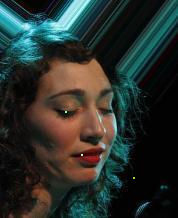

np.float32(0.5090372)

In [14]:
i = 0
img = Image.open(f'data/img_align_celeba/img_align_celeba/{true_images_x[i]}').convert('RGB')
img = get_perturb_image_from_pillow(img, results[i][0], diameter=2)
display(img)
get_pred_from_pillow(img)

## Particle Swarm Optimization

In [19]:
%%time
results = []
for i in tqdm(range(10)):
    img_ = Image.open(f'data/img_align_celeba/img_align_celeba/{true_images_x[i]}').convert('RGB')
    attack = pso_one_pixel_attack(
        alexnet_model, 
        image=img_,
        true_class=true_images_y[i],
        max_pixels=3,
        diameter=2,
        time_limit=10*60,
        swarm_size=1000,
        iters=3000
    )
    results.append(attack)

100%|██████████| 10/10 [1:22:41<00:00, 496.14s/it]

CPU times: user 6h 4min 10s, sys: 21min 24s, total: 6h 25min 35s
Wall time: 1h 22min 41s


In [20]:
results

[([[71, 110, 195, 167, 236],
   [65, 111, 242, 254, 214],
   [68, 100, 222, 91, 154]],
  np.float64(0.5179386138916016)),
 ([[108, 130, 20, 8, 136], [69, 123, 1, 117, 254], [61, 131, 0, 127, 124]],
  np.float64(0.033403217792510986)),
 ([[115, 112, 2, 243, 243], [97, 90, 155, 240, 247], [113, 113, 34, 241, 242]],
  np.float64(0.4911045432090759)),
 ([[72, 98, 17, 5, 52], [81, 158, 27, 4, 235], [93, 100, 28, 2, 49]],
  np.float64(0.007112075109034777)),
 ([[101, 95, 0, 103, 82], [62, 112, 0, 23, 253], [87, 133, 129, 179, 156]],
  np.float64(0.0010686395689845085)),
 ([[105, 131, 24, 8, 178], [69, 127, 87, 35, 15], [96, 77, 134, 126, 129]],
  np.float64(0.5007540583610535)),
 ([[106, 115, 234, 253, 249],
   [68, 115, 164, 165, 252],
   [72, 65, 140, 134, 116]],
  np.float64(0.007558325305581093)),
 ([[72, 111, 235, 239, 139], [100, 115, 161, 247, 249], [75, 94, 98, 68, 2]],
  np.float64(0.05708540603518486)),
 ([[80, 91, 2, 252, 124], [100, 87, 14, 245, 49], [99, 94, 99, 7, 47]],
  np.fl

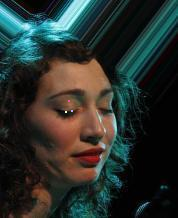

np.float32(0.5179569)

In [169]:
with open('results/pso_results.pickle', 'rb') as f:
    results = pickle.load(f)

i = 0
img = Image.open(f'data/img_align_celeba/img_align_celeba/{true_images_x[i]}').convert('RGB')
img = get_perturb_image_from_pillow(img, results[0][0], diameter=2)
display(img)
get_pred_from_pillow(img)

## Genetic Algorithm

In [12]:
%%time
results = []
for i in tqdm(range(10)):
    img_ = Image.open(f'data/img_align_celeba/img_align_celeba/{true_images_x[i]}').convert('RGB')
    attack = ga_one_pixel_attack(
        img=img_,
        true_label=true_images_y[i],
        model=alexnet_model,
        pixels_count=3,
        diameter=2,
        epochs=1000,
        population_size=1000,
        timeout=10*60,
    )
    results.append(attack)

100%|██████████| 10/10 [1:15:52<00:00, 455.28s/it]

CPU times: user 3h 45min 31s, sys: 11min 3s, total: 3h 56min 35s
Wall time: 1h 15min 52s


In [37]:
results

[[20,
  83,
  252,
  216,
  32,
  111,
  65,
  252,
  228,
  251,
  153,
  80,
  248,
  81,
  204,
  0.5155540704727173],
 [130,
  63,
  0,
  1,
  4,
  130,
  65,
  3,
  1,
  6,
  131,
  108,
  0,
  1,
  253,
  np.float32(0.06385827)],
 [113,
  63,
  2,
  164,
  199,
  99,
  113,
  26,
  162,
  170,
  111,
  68,
  40,
  217,
  234,
  0.5576413869857788],
 [100,
  100,
  0,
  253,
  0,
  155,
  88,
  1,
  0,
  247,
  94,
  81,
  7,
  0,
  0,
  0.014892282895743847],
 [95,
  101,
  1,
  0,
  0,
  115,
  61,
  0,
  251,
  2,
  113,
  62,
  0,
  253,
  254,
  0.01068152580410242],
 [130,
  106,
  23,
  24,
  134,
  85,
  109,
  225,
  22,
  224,
  123,
  69,
  1,
  3,
  64,
  np.float32(0.5557866)],
 [115,
  100,
  233,
  78,
  252,
  115,
  68,
  160,
  186,
  251,
  115,
  106,
  204,
  237,
  254,
  0.00827404297888279],
 [115,
  68,
  253,
  249,
  254,
  146,
  42,
  247,
  249,
  249,
  115,
  103,
  253,
  245,
  252,
  0.10986825078725815],
 [108,
  61,
  3,
  15,
  250,
  105,
  8

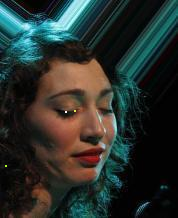

np.float32(0.5068471)

In [114]:
with open('results/ga_results.pickle', 'rb') as f:
    results = pickle.load(f)

i = 0
img = Image.open(f'data/img_align_celeba/img_align_celeba/{true_images_x[i]}').convert('RGB')
attack = np.array(results[i][:15]).reshape(3, 5)

for p in attack:
    p[0], p[1] = p[1], p[0]

img = get_perturb_image_from_pillow(img, attack, diameter=2)
display(img)
get_pred_from_pillow(img)

# ResNet

In [7]:
import pickle
with open('results/true_images_resnet.pickle', 'rb') as f:
    true_images_x, true_images_y = pickle.load(f)

In [8]:
true_images_x = true_images_x[:30]
true_images_y = true_images_y[:30]
true_images_x.shape, true_images_y.shape 

((30,), (30,))

In [9]:
resnet_18_model = models.resnet18()
resnet_18_model.fc = nn.Linear(512, 1)
resnet_18_model.load_state_dict(torch.load('models/best_resnet18_2.pth'))
resnet_18_model.eval()
resnet_18_model.to(DEVICE)
pass

In [10]:
def get_pred_from_pillow(image):
    image = val_tfms(image).unsqueeze(0)
    image = image.to(DEVICE)
    with torch.no_grad():
        output = resnet_18_model(image).squeeze(1)
    return torch.sigmoid(output).cpu().numpy()[0]

In [11]:
def get_perturb_image_from_pillow(img, attack, diameter=1, ga=False):
    img_arr = np.array(img)
    img_mod = img_arr.copy()
    for xi in attack:
        x_coord, y_coord, r, g, b = xi
        for delta_x in range(diameter):
            for delta_y in range(diameter):
                img_mod[y_coord + delta_y, x_coord + delta_x] = [r, g, b]
                    
    return Image.fromarray(img_mod)

## Differential Evolution

In [12]:
%%time
results = []
for i in tqdm(range(10)):
    img_ = Image.open(f'data/img_align_celeba/img_align_celeba/{true_images_x[i]}').convert('RGB')
    attack = one_pixel_attack(
        pil_image=img_, 
        model=resnet_18_model, 
        target=1 - true_images_y[i], 
        num_pixels=3,
        diameter=2,
        timelimit=10*60,
        maxiter=200,
        popsize=400,
    )
    results.append(attack)

100%|████████████████████████████████████████| 10/10 [1:30:55<00:00, 545.56s/it]

CPU times: user 9h 5min 24s, sys: 6.01 s, total: 9h 5min 30s
Wall time: 1h 30min 55s


In [13]:
results

[([(81, 63, 77, 61, 121), (88, 96, 50, 16, 95), (76, 163, 149, 13, 0)],
  np.float32(0.15135601)),
 ([(75, 111, 83, 202, 239),
   (54, 145, 166, 159, 235),
   (63, 179, 240, 161, 117)],
  np.float32(0.25894192)),
 ([(108, 121, 163, 8, 26), (119, 124, 35, 30, 19), (120, 142, 133, 79, 62)],
  np.float32(0.9916469)),
 ([(62, 110, 32, 189, 252), (63, 102, 251, 4, 201), (84, 162, 191, 67, 226)],
  np.float32(0.30177796)),
 ([(96, 61, 137, 233, 190), (83, 57, 142, 243, 234), (89, 51, 212, 34, 103)],
  np.float32(0.0005844705)),
 ([(60, 122, 27, 41, 21), (72, 109, 223, 22, 78), (105, 58, 237, 174, 145)],
  np.float32(0.0021542052)),
 ([(82, 160, 37, 18, 146), (85, 138, 75, 90, 22), (91, 157, 29, 41, 144)],
  np.float32(0.3766024)),
 ([(66, 126, 130, 13, 107), (92, 116, 174, 33, 35), (98, 124, 73, 75, 25)],
  np.float32(0.59907866)),
 ([(152, 155, 216, 146, 195),
   (86, 180, 136, 242, 116),
   (47, 142, 220, 63, 95)],
  np.float32(6.250768e-05)),
 ([(68, 117, 31, 251, 209),
   (65, 114, 125, 

In [15]:
import pickle
with open('results/de_results_resnet.pickle', 'wb') as f:
    pickle.dump(results, f)

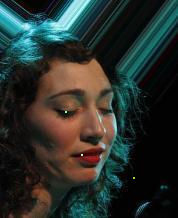

np.float32(0.5090372)

In [14]:
i = 0
img = Image.open(f'data/img_align_celeba/img_align_celeba/{true_images_x[i]}').convert('RGB')
img = get_perturb_image_from_pillow(img, results[i][0], diameter=2)
display(img)
get_pred_from_pillow(img)

## Particle Swarm Optimization

In [16]:
%%time
results_2 = []
for i in tqdm(range(10)):
    img_ = Image.open(f'data/img_align_celeba/img_align_celeba/{true_images_x[i]}').convert('RGB')
    attack = pso_one_pixel_attack(
        resnet_18_model, 
        image=img_,
        true_class=true_images_y[i],
        max_pixels=3,
        diameter=2,
        time_limit=10*60,
        swarm_size=400,
        iters=3000
    )
    results_2.append(attack)

100%|████████████████████████████████████████| 10/10 [1:40:02<00:00, 600.27s/it]

CPU times: user 5h 55min, sys: 17min 20s, total: 6h 12min 21s
Wall time: 1h 40min 2s


In [17]:
results_2

[([[102, 63, 212, 35, 98], [88, 97, 74, 3, 3], [75, 109, 144, 253, 152]],
  np.float64(0.15461184084415436)),
 ([[91, 140, 128, 253, 235], [73, 111, 184, 236, 106], [63, 110, 4, 110, 245]],
  np.float64(0.2939049005508423)),
 ([[115, 90, 239, 17, 164], [120, 125, 42, 26, 26], [108, 122, 10, 0, 148]],
  np.float64(0.0052735209465026855)),
 ([[60, 112, 37, 225, 234], [107, 103, 143, 242, 253], [91, 88, 244, 245, 95]],
  np.float64(0.31640011072158813)),
 ([[78, 60, 108, 251, 100], [89, 57, 170, 145, 193], [63, 119, 135, 2, 1]],
  np.float64(0.0006586374947801232)),
 ([[104, 57, 137, 235, 234], [46, 89, 140, 116, 163], [60, 124, 7, 1, 5]],
  np.float64(0.0024742335081100464)),
 ([[82, 118, 0, 160, 172], [102, 112, 177, 246, 249], [95, 157, 129, 1, 97]],
  np.float64(0.43197333812713623)),
 ([[89, 109, 56, 249, 234], [94, 118, 77, 1, 23], [67, 124, 2, 3, 3]],
  np.float64(0.4289090037345886)),
 ([[59, 128, 248, 119, 178], [50, 73, 90, 241, 241], [48, 140, 15, 10, 15]],
  np.float64(0.00015

In [18]:
with open('results/pso_results_resnet.pickle', 'wb') as f:
    pickle.dump(results_2, f)

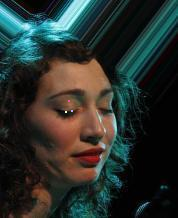

np.float32(0.5179569)

In [169]:
with open('results/pso_results.pickle', 'rb') as f:
    results = pickle.load(f)

i = 0
img = Image.open(f'data/img_align_celeba/img_align_celeba/{true_images_x[i]}').convert('RGB')
img = get_perturb_image_from_pillow(img, results[0][0], diameter=2)
display(img)
get_pred_from_pillow(img)

## Genetic Algorithm

In [19]:
%%time
results_3 = []
for i in tqdm(range(10)):
    img_ = Image.open(f'data/img_align_celeba/img_align_celeba/{true_images_x[i]}').convert('RGB')
    attack = ga_one_pixel_attack(
        img=img_,
        true_label=true_images_y[i],
        model=resnet_18_model,
        pixels_count=3,
        diameter=2,
        epochs=1000,
        population_size=400,
        timeout=10*60,
    )
    results_3.append(attack)

  0%|                                                    | 0/10 [00:00<?, ?it/s]

epoch 0	 mean: 0.05	 max: 0.07	 time: 0.45
epoch 20	 mean: 0.05	 max: 0.09	 time: 0.44
epoch 40	 mean: 0.05	 max: 0.11	 time: 0.44
epoch 60	 mean: 0.05	 max: 0.11	 time: 0.44
epoch 80	 mean: 0.05	 max: 0.12	 time: 0.44
epoch 100	 mean: 0.05	 max: 0.12	 time: 0.44
epoch 120	 mean: 0.05	 max: 0.12	 time: 0.44
epoch 140	 mean: 0.06	 max: 0.13	 time: 0.44
epoch 160	 mean: 0.06	 max: 0.13	 time: 0.44
epoch 180	 mean: 0.06	 max: 0.13	 time: 0.44
epoch 200	 mean: 0.06	 max: 0.13	 time: 0.44
epoch 220	 mean: 0.06	 max: 0.13	 time: 0.45
epoch 240	 mean: 0.06	 max: 0.14	 time: 0.44
epoch 260	 mean: 0.06	 max: 0.14	 time: 0.44
epoch 280	 mean: 0.06	 max: 0.15	 time: 0.44
epoch 300	 mean: 0.06	 max: 0.15	 time: 0.44
epoch 320	 mean: 0.06	 max: 0.15	 time: 0.44
epoch 340	 mean: 0.06	 max: 0.15	 time: 0.44
epoch 360	 mean: 0.06	 max: 0.16	 time: 0.44
epoch 380	 mean: 0.06	 max: 0.17	 time: 0.44
epoch 400	 mean: 0.07	 max: 0.17	 time: 0.44
epoch 420	 mean: 0.06	 max: 0.17	 time: 0.44
epoch 440	 mean:

 10%|████                                     | 1/10 [07:29<1:07:23, 449.23s/it]

epoch 0	 mean: 0.04	 max: 0.11	 time: 0.44
epoch 20	 mean: 0.05	 max: 0.14	 time: 0.45
epoch 40	 mean: 0.05	 max: 0.17	 time: 0.44
epoch 60	 mean: 0.06	 max: 0.19	 time: 0.44
epoch 80	 mean: 0.06	 max: 0.25	 time: 0.44
epoch 100	 mean: 0.06	 max: 0.30	 time: 0.44
epoch 120	 mean: 0.07	 max: 0.30	 time: 0.44
epoch 140	 mean: 0.08	 max: 0.30	 time: 0.46
epoch 160	 mean: 0.08	 max: 0.30	 time: 0.44
epoch 180	 mean: 0.08	 max: 0.30	 time: 0.44
epoch 200	 mean: 0.09	 max: 0.32	 time: 0.44
epoch 220	 mean: 0.09	 max: 0.35	 time: 0.45
epoch 240	 mean: 0.10	 max: 0.36	 time: 0.44
epoch 260	 mean: 0.10	 max: 0.37	 time: 0.44
epoch 280	 mean: 0.11	 max: 0.40	 time: 0.44
epoch 300	 mean: 0.12	 max: 0.43	 time: 0.44
epoch 320	 mean: 0.12	 max: 0.44	 time: 0.44
epoch 340	 mean: 0.13	 max: 0.44	 time: 0.44
epoch 360	 mean: 0.13	 max: 0.45	 time: 0.44
epoch 380	 mean: 0.14	 max: 0.45	 time: 0.44
epoch 400	 mean: 0.14	 max: 0.46	 time: 0.44
epoch 420	 mean: 0.14	 max: 0.46	 time: 0.44
epoch 440	 mean:

 20%|████████▌                                  | 2/10 [13:22<52:21, 392.66s/it]

epoch 0	 mean: 6.18	 max: 0.00	 time: 0.45
epoch 20	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 40	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 60	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 80	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 100	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 120	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 140	 mean: 0.00	 max: 0.01	 time: 0.44
epoch 160	 mean: 0.00	 max: 0.01	 time: 0.44
epoch 180	 mean: 0.00	 max: 0.01	 time: 0.44
epoch 200	 mean: 0.00	 max: 0.01	 time: 0.44
epoch 220	 mean: 0.00	 max: 0.01	 time: 0.44
epoch 240	 mean: 0.00	 max: 0.01	 time: 0.44
epoch 260	 mean: 0.00	 max: 0.01	 time: 0.44
epoch 280	 mean: 0.00	 max: 0.01	 time: 0.44
epoch 300	 mean: 0.00	 max: 0.01	 time: 0.44


 30%|████████████▉                              | 3/10 [15:38<32:09, 275.63s/it]

epoch 0	 mean: 0.09	 max: 0.14	 time: 0.45
epoch 20	 mean: 0.09	 max: 0.17	 time: 0.44
epoch 40	 mean: 0.09	 max: 0.18	 time: 0.44
epoch 60	 mean: 0.10	 max: 0.20	 time: 0.44
epoch 80	 mean: 0.10	 max: 0.20	 time: 0.44
epoch 100	 mean: 0.10	 max: 0.21	 time: 0.44
epoch 120	 mean: 0.10	 max: 0.24	 time: 0.44
epoch 140	 mean: 0.10	 max: 0.24	 time: 0.44
epoch 160	 mean: 0.10	 max: 0.24	 time: 0.44
epoch 180	 mean: 0.10	 max: 0.28	 time: 0.44
epoch 200	 mean: 0.10	 max: 0.28	 time: 0.45
epoch 220	 mean: 0.11	 max: 0.29	 time: 0.44
epoch 240	 mean: 0.11	 max: 0.30	 time: 0.44
epoch 260	 mean: 0.11	 max: 0.36	 time: 0.44
epoch 280	 mean: 0.11	 max: 0.39	 time: 0.44
epoch 300	 mean: 0.12	 max: 0.39	 time: 0.44
epoch 320	 mean: 0.13	 max: 0.39	 time: 0.44
epoch 340	 mean: 0.14	 max: 0.42	 time: 0.44
epoch 360	 mean: 0.14	 max: 0.43	 time: 0.44
epoch 380	 mean: 0.15	 max: 0.44	 time: 0.44
epoch 400	 mean: 0.15	 max: 0.44	 time: 0.44
epoch 420	 mean: 0.15	 max: 0.45	 time: 0.44
epoch 440	 mean:

 40%|█████████████████▏                         | 4/10 [21:04<29:33, 295.63s/it]

epoch 0	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 20	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 40	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 60	 mean: 0.00	 max: 0.00	 time: 0.45
epoch 80	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 100	 mean: 0.00	 max: 0.00	 time: 0.45
epoch 120	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 140	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 160	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 180	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 200	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 220	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 240	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 260	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 280	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 300	 mean: 0.00	 max: 0.00	 time: 0.44


 50%|█████████████████████▌                     | 5/10 [23:21<19:50, 238.18s/it]

epoch 0	 mean: 0.00	 max: 0.00	 time: 0.45
epoch 20	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 40	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 60	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 80	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 100	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 120	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 140	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 160	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 180	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 200	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 220	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 240	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 260	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 280	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 300	 mean: 0.00	 max: 0.00	 time: 0.44


 60%|█████████████████████████▊                 | 6/10 [25:37<13:34, 203.63s/it]

epoch 0	 mean: 0.09	 max: 0.15	 time: 0.44
epoch 20	 mean: 0.10	 max: 0.24	 time: 0.44
epoch 40	 mean: 0.11	 max: 0.24	 time: 0.44
epoch 60	 mean: 0.11	 max: 0.27	 time: 0.47
epoch 80	 mean: 0.12	 max: 0.30	 time: 0.44
epoch 100	 mean: 0.12	 max: 0.30	 time: 0.44
epoch 120	 mean: 0.12	 max: 0.35	 time: 0.44
epoch 140	 mean: 0.12	 max: 0.39	 time: 0.45
epoch 160	 mean: 0.12	 max: 0.39	 time: 0.44
epoch 180	 mean: 0.13	 max: 0.39	 time: 0.44
epoch 200	 mean: 0.13	 max: 0.39	 time: 0.46
epoch 220	 mean: 0.13	 max: 0.41	 time: 0.44
epoch 240	 mean: 0.14	 max: 0.41	 time: 0.44
epoch 260	 mean: 0.14	 max: 0.45	 time: 0.44
epoch 280	 mean: 0.14	 max: 0.45	 time: 0.44


 70%|██████████████████████████████             | 7/10 [27:51<09:01, 180.63s/it]

epoch 0	 mean: 0.04	 max: 0.13	 time: 0.45
epoch 20	 mean: 0.06	 max: 0.26	 time: 0.44
epoch 40	 mean: 0.08	 max: 0.30	 time: 0.44
epoch 60	 mean: 0.09	 max: 0.39	 time: 0.44
epoch 80	 mean: 0.09	 max: 0.39	 time: 0.44
epoch 100	 mean: 0.10	 max: 0.39	 time: 0.44
epoch 120	 mean: 0.10	 max: 0.42	 time: 0.44
epoch 140	 mean: 0.11	 max: 0.42	 time: 0.44
epoch 160	 mean: 0.11	 max: 0.42	 time: 0.44
epoch 180	 mean: 0.11	 max: 0.42	 time: 0.44
epoch 200	 mean: 0.12	 max: 0.42	 time: 0.44
epoch 220	 mean: 0.13	 max: 0.43	 time: 0.44
epoch 240	 mean: 0.13	 max: 0.43	 time: 0.44
epoch 260	 mean: 0.13	 max: 0.43	 time: 0.44
epoch 280	 mean: 0.13	 max: 0.43	 time: 0.44
epoch 300	 mean: 0.13	 max: 0.43	 time: 0.44
epoch 320	 mean: 0.14	 max: 0.44	 time: 0.44
epoch 340	 mean: 0.14	 max: 0.44	 time: 0.44
epoch 360	 mean: 0.14	 max: 0.45	 time: 0.44
epoch 380	 mean: 0.14	 max: 0.45	 time: 0.44
epoch 400	 mean: 0.14	 max: 0.45	 time: 0.44
epoch 420	 mean: 0.15	 max: 0.45	 time: 0.43
epoch 440	 mean:

 80%|██████████████████████████████████▍        | 8/10 [32:18<06:56, 208.11s/it]

epoch 0	 mean: 3.28	 max: 6.25	 time: 0.44
epoch 20	 mean: 3.55	 max: 8.20	 time: 0.44
epoch 40	 mean: 3.66	 max: 0.00	 time: 0.44
epoch 60	 mean: 3.82	 max: 0.00	 time: 0.44
epoch 80	 mean: 3.96	 max: 0.00	 time: 0.44
epoch 100	 mean: 3.92	 max: 0.00	 time: 0.44
epoch 120	 mean: 4.07	 max: 0.00	 time: 0.44
epoch 140	 mean: 4.17	 max: 0.00	 time: 0.44
epoch 160	 mean: 4.29	 max: 0.00	 time: 0.43
epoch 180	 mean: 4.61	 max: 0.00	 time: 0.44
epoch 200	 mean: 4.74	 max: 0.00	 time: 0.44
epoch 220	 mean: 4.81	 max: 0.00	 time: 0.44
epoch 240	 mean: 4.87	 max: 0.00	 time: 0.44
epoch 260	 mean: 5.11	 max: 0.00	 time: 0.44
epoch 280	 mean: 5.41	 max: 0.00	 time: 0.44
epoch 300	 mean: 5.52	 max: 0.00	 time: 0.44


 90%|██████████████████████████████████████▋    | 9/10 [34:32<03:05, 185.22s/it]

epoch 0	 mean: 0.00	 max: 0.00	 time: 0.45
epoch 20	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 40	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 60	 mean: 0.00	 max: 0.00	 time: 0.43
epoch 80	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 100	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 120	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 140	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 160	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 180	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 200	 mean: 0.00	 max: 0.00	 time: 0.44
epoch 220	 mean: 0.00	 max: 0.01	 time: 0.44
epoch 240	 mean: 0.00	 max: 0.01	 time: 0.44
epoch 260	 mean: 0.00	 max: 0.01	 time: 0.43
epoch 280	 mean: 0.00	 max: 0.01	 time: 0.43
epoch 300	 mean: 0.00	 max: 0.01	 time: 0.43


100%|██████████████████████████████████████████| 10/10 [36:47<00:00, 220.76s/it]

CPU times: user 1h 54min 3s, sys: 5min 32s, total: 1h 59min 36s
Wall time: 36min 47s


In [20]:
results_3

[[163,
  76,
  254,
  1,
  1,
  109,
  75,
  24,
  254,
  252,
  93,
  88,
  3,
  0,
  1,
  0.2258613556623459],
 [111,
  60,
  0,
  253,
  250,
  161,
  79,
  253,
  0,
  254,
  111,
  73,
  0,
  254,
  253,
  0.510875940322876],
 [121,
  108,
  98,
  4,
  17,
  123,
  117,
  180,
  2,
  3,
  122,
  57,
  12,
  3,
  13,
  np.float32(0.016587853)],
 [111,
  60,
  0,
  252,
  254,
  145,
  42,
  252,
  248,
  253,
  111,
  73,
  5,
  251,
  249,
  0.5002971291542053],
 [58,
  75,
  144,
  222,
  232,
  59,
  101,
  51,
  204,
  248,
  123,
  89,
  65,
  115,
  52,
  0.0008689537062309682],
 [123,
  63,
  4,
  3,
  43,
  57,
  104,
  54,
  221,
  221,
  171,
  138,
  241,
  168,
  213,
  0.002617074642330408],
 [108,
  114,
  12,
  133,
  154,
  157,
  92,
  243,
  4,
  32,
  111,
  104,
  111,
  247,
  240,
  0.5242156982421875],
 [123,
  66,
  90,
  5,
  9,
  122,
  108,
  248,
  1,
  2,
  122,
  96,
  176,
  2,
  2,
  np.float32(0.5007135)],
 [140,
  48,
  2,
  18,
  27,
  180,
  88,


In [22]:
with open('results/ga_results_resnet.pickle', 'wb') as f:
    pickle.dump(results_3, f)

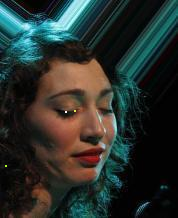

np.float32(0.5068471)

In [114]:
with open('results/ga_results.pickle', 'rb') as f:
    results = pickle.load(f)

i = 0
img = Image.open(f'data/img_align_celeba/img_align_celeba/{true_images_x[i]}').convert('RGB')
attack = np.array(results[i][:15]).reshape(3, 5)

for p in attack:
    p[0], p[1] = p[1], p[0]

img = get_perturb_image_from_pillow(img, attack, diameter=2)
display(img)
get_pred_from_pillow(img)

# EDA

## AlexNet

In [23]:
with open('results/de_results.pickle', 'rb') as f:
    de_results = pickle.load(f)

with open('results/pso_results.pickle', 'rb') as f:
    spo_results = pickle.load(f)

with open('results/ga_results.pickle', 'rb') as f:
    ga_results = pickle.load(f)

### Differential Evolution

In [24]:
de_scores = np.array([min(float(result[-1]), 0.5) if result[-1] < 0.6 else min(float(1 - result[-1]), 0.5) for result in de_results])
de_scores

array([0.5       , 0.02601767, 0.36520654, 0.00474863, 0.0007258 ,
       0.49362826, 0.00536014, 0.03573732, 0.00342142, 0.01511796])

In [25]:
sum(de_scores >= 0.5), np.mean(de_scores)

(np.int64(1), np.float64(0.14499637378030455))

### Particle Swarm Optimization

In [26]:
spo_scores = np.array([min(float(result[-1]), 0.5) for result in spo_results])
spo_scores

array([0.5       , 0.03340322, 0.49110454, 0.00711208, 0.00106864,
       0.5       , 0.00755833, 0.05708541, 0.00383996, 0.02380035])

In [27]:
sum(spo_scores >= 0.5), np.mean(spo_scores)

(np.int64(2), np.float64(0.16249725124798714))

### Genetic Algorithm

In [28]:
ga_scores = np.array([min(float(result[-1]), 0.5) for result in ga_results])
ga_scores

array([0.5       , 0.06792158, 0.5       , 0.01705807, 0.00488412,
       0.5       , 0.00818149, 0.12433746, 0.00669252, 0.04347556])

In [29]:
sum(ga_scores >= 0.5), np.mean(ga_scores)

(np.int64(3), np.float64(0.17725508068688214))

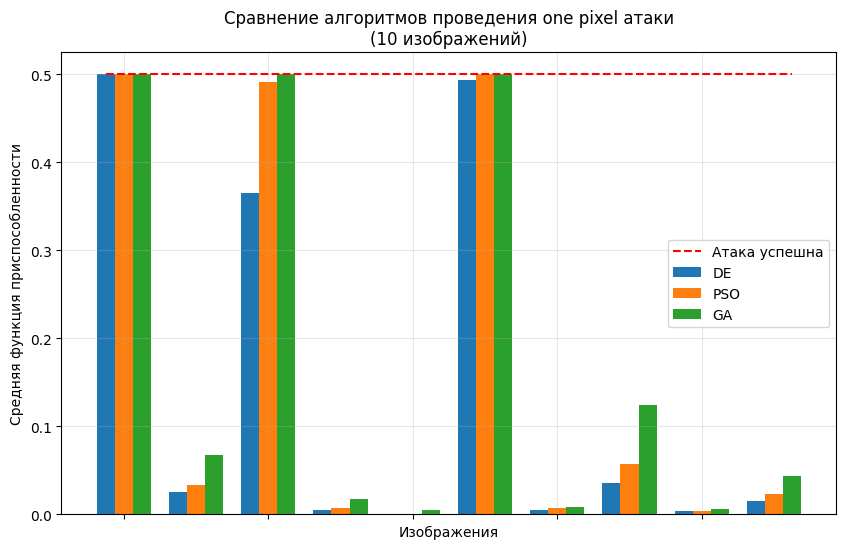

In [30]:
import numpy as np

labels = [f'Фото {i+1}' for i in range(10)]

x = np.arange(len(labels)) # Позиции на оси X
width = 0.25 # Ширина столбцов

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width, de_scores, width, label='DE')
ax.bar(x, spo_scores, width, label='PSO')
ax.bar(x + width, ga_scores, width, label='GA')

ax.plot([-0.25, 9.25], [0.5, 0.5], color='red', linestyle='--', label='Атака успешна')

ax.set_xlabel('Изображения')
ax.set_ylabel('Средняя функция приспособленности')
ax.set_title('Сравнение алгоритмов проведения one pixel атаки\n(10 изображений)')
ax.legend()
ax.grid(alpha=0.3)
plt.tick_params(labelbottom=False)

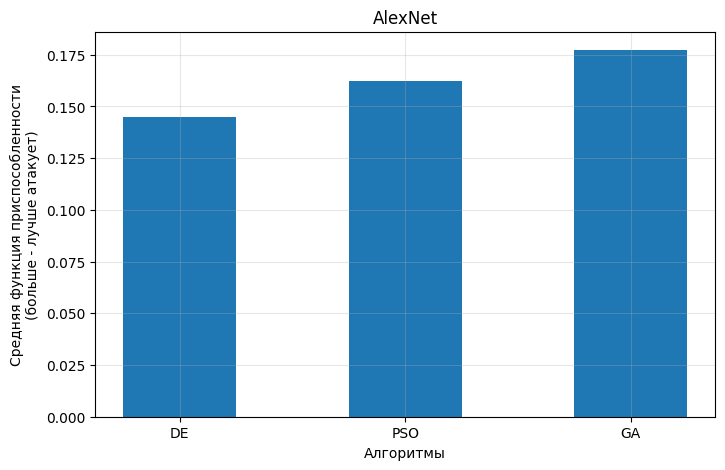

In [31]:
mean_f_algorithm1 = np.mean(de_scores)
mean_f_algorithm2 = np.mean(spo_scores)
mean_f_algorithm3 = np.mean(ga_scores)

labels = ['DE', 'PSO', 'GA']
means = [mean_f_algorithm1, mean_f_algorithm2, mean_f_algorithm3]

fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(labels, means, width=0.5, )


ax.set_xlabel('Алгоритмы')
ax.set_ylabel('Средняя функция приспособленности\n(больше - лучше атакует)')
ax.set_title('AlexNet')

ax.grid(alpha=0.3)
plt.show()

## ResNet

In [21]:
with open('results/de_results_resnet.pickle', 'rb') as f:
    de_results = pickle.load(f)

with open('results/pso_results_resnet.pickle', 'rb') as f:
    spo_results = pickle.load(f)

with open('results/ga_results_resnet.pickle', 'rb') as f:
    ga_results = pickle.load(f)

### Differential Evolution

In [22]:
de_scores = np.array([min(float(result[-1]), 0.5) if result[-1] < 0.6 else min(float(1 - result[-1]), 0.5) for result in de_results])
de_scores

array([1.51356012e-01, 2.58941919e-01, 8.35311413e-03, 3.01777959e-01,
       5.84470516e-04, 2.15420523e-03, 3.76602411e-01, 5.00000000e-01,
       6.25076791e-05, 6.59623602e-03])

In [7]:
sum(de_scores >= 0.5), np.mean(de_scores)

(np.int64(1), np.float64(0.1606428833954851))

### Particle Swarm Optimization

In [8]:
spo_scores = np.array([min(float(result[-1]), 0.5) for result in spo_results])
spo_scores

array([1.54611841e-01, 2.93904901e-01, 5.27352095e-03, 3.16400111e-01,
       6.58637495e-04, 2.47423351e-03, 4.31973338e-01, 4.28909004e-01,
       1.52986555e-04, 8.04120861e-03])

In [9]:
sum(spo_scores >= 0.5), np.mean(spo_scores)

(np.int64(0), np.float64(0.16423997810925356))

### Genetic Algorithm

In [10]:
ga_scores = np.array([min(float(result[-1]), 0.5) for result in ga_results])
ga_scores

array([2.25861356e-01, 5.00000000e-01, 1.65878534e-02, 5.00000000e-01,
       8.68953706e-04, 2.61707464e-03, 5.00000000e-01, 5.00000000e-01,
       1.83487602e-04, 1.05737904e-02])

In [11]:
sum(ga_scores >= 0.5), np.mean(ga_scores)

(np.int64(4), np.float64(0.22566925154533238))

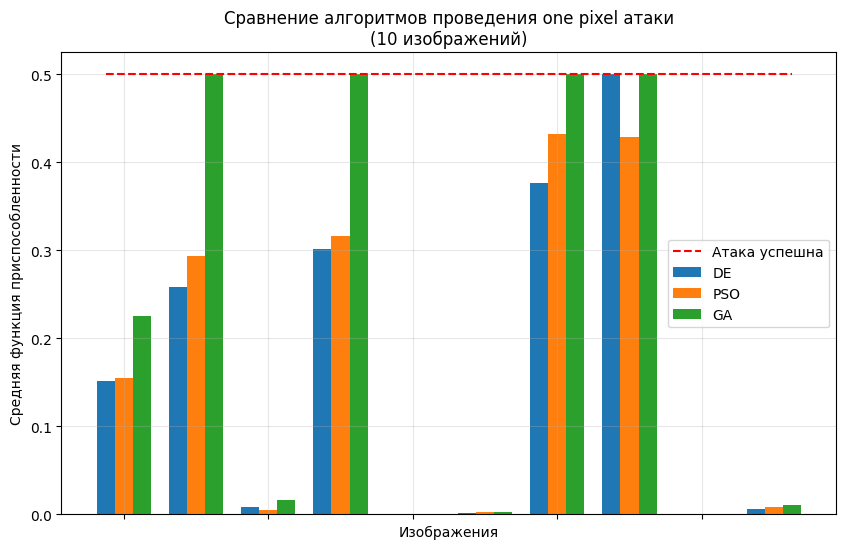

In [12]:
import numpy as np

labels = [f'Фото {i+1}' for i in range(10)]

x = np.arange(len(labels)) # Позиции на оси X
width = 0.25 # Ширина столбцов

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width, de_scores, width, label='DE')
ax.bar(x, spo_scores, width, label='PSO')
ax.bar(x + width, ga_scores, width, label='GA')

ax.plot([-0.25, 9.25], [0.5, 0.5], color='red', linestyle='--', label='Атака успешна')

ax.set_xlabel('Изображения')
ax.set_ylabel('Средняя функция приспособленности')
ax.set_title('Сравнение алгоритмов проведения one pixel атаки\n(10 изображений)')
ax.legend()
ax.grid(alpha=0.3)
plt.tick_params(labelbottom=False)

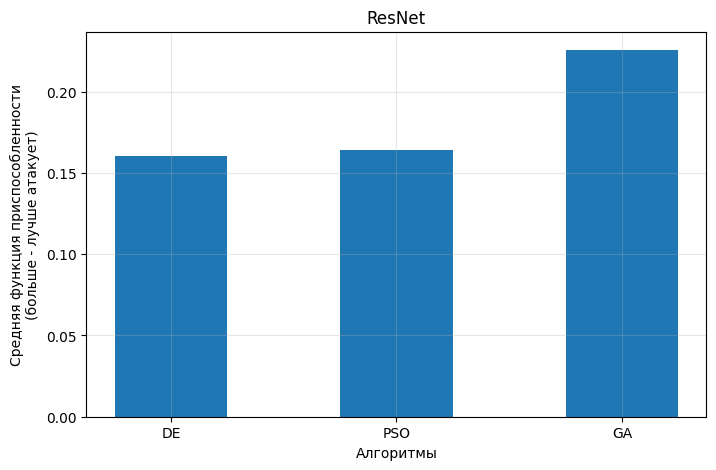

In [14]:
mean_f_algorithm1 = np.mean(de_scores)
mean_f_algorithm2 = np.mean(spo_scores)
mean_f_algorithm3 = np.mean(ga_scores)

labels = ['DE', 'PSO', 'GA']
means = [mean_f_algorithm1, mean_f_algorithm2, mean_f_algorithm3]

fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(labels, means, width=0.5, )


ax.set_xlabel('Алгоритмы')
ax.set_ylabel('Средняя функция приспособленности\n(больше - лучше атакует)')
ax.set_title('ResNet')

ax.grid(alpha=0.3)
plt.show()